In [1]:
#Making the necessary imports
import os
import numpy as np
from numpy import matrix
import scipy.optimize as theMinimiser
from iminuit import Minuit
import math
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

## Part 1

### Plotting the data

In [2]:
#Load the muon decay times
decay_times = np.loadtxt("datafile-exp.txt", dtype=float)

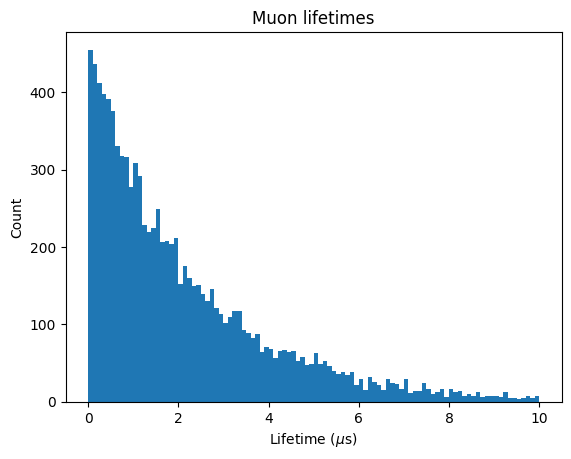

In [3]:
plt.hist(decay_times, bins=100)
plt.title("Muon lifetimes")
plt.xlabel("Lifetime ($\mu$s)")
plt.ylabel("Count")
plt.show()

### Maximum likelihood fit to the data

Throughout part 1:

"tau" = the lifetime of muons

In [4]:
# Generate the normalised exponential PDF
def Generate_PDF(decay_times,tau,t_low,t_high):
    C = np.exp(-t_low/tau)-np.exp(-t_high/tau) # Calculate the normalisation constant
    return (1/(tau*C))*np.exp(-decay_times/tau) # Return the normalised exponential PDF

In [5]:
# Calculate the negative of the log of the joint likelihood
# This is the function we are trying to minimise with the minimiser, given different values of tau
def NLL(tau):
    P = Generate_PDF(decay_times,tau,t_low,t_high)
    return -np.sum(np.log(P))

#### Using the correct PDF normalisation (range 0-10)

In [6]:
# Using the correctly normalised pdf

# Setting the range of our time data for use in normalisation
t_low = 0
t_high = 10

# Set the minimisation parameters
m = Minuit(NLL, tau=1)

# Set the errors on the initial start values
m.errors=[0.1]

# Set the increase in NLL for the 1-SD error calculation
m.errordef=0.5

# Run the minimisation
m = m.migrad()

In [7]:
#C = np.exp(0)-np.exp(-10/2.2)

In [8]:
# Printing the final result and its error
fstr = "{0:2.4f}"
val = m.values["tau"]
err = m.errors["tau"]
print("{:2s}".format("tau"), "=  ", fstr.format(val), " +/- ", fstr.format(err))

tau =   2.2043  +/-  0.0250


#### Without using PDF normalisation (range 0-inf)

In [9]:
# Using the un-normalised pdf

# Not using the same range as our time data
t_low = 0
t_high = np.inf

# Set the minimisation parameters
m = Minuit(NLL, tau=1)

# Set the errors on the initial start values
m.errors=[0.1]

# Set the increase in NLL for the 1-SD error calculation
m.errordef=0.5

# Run the minimisation
m = m.migrad()

In [10]:
# Printing the final result and its error
fstr = "{0:2.4f}"
val = m.values["tau"]
err = m.errors["tau"]
print("{:2s}".format("tau"), "=  ", fstr.format(val), " +/- ", fstr.format(err))

tau =   2.0961  +/-  0.0210


### Interpretation of the results

When we perform maximum likelihood fitting to the correctly normalised PDF, in the range of our data, we obtain a muon life time that is correct within the error margin.

When we perform maximum likelihood fitting to the un-normalised PDF, which assumes a data range that extends beyond the recorded data range, we obtain an underestimate for the muon life time that cannot be explained by the error. 

In the first case we correctly normalise the PDF to have unit area over our data range. This allows the lifetime to be determined accurately as the minimiser only fits the exponential distribution to the range of data that we have taken.

In the latter case the underestimate for the muon lifetime comes from not taking into account that we have limited data to fit. Due to the limit in our number of data samples we do not have a representative distribution of the real exponential distribution which underlies this process. Instead we effectively have a cropped exponential distribution which has the tail missing. This means we do not account for the rare decay samples that would decay with much longer lifetimes and so we underestimate the muon lifetime when fitting in this way.

## Part 2

Throughout part 2:

"tau" = the "lifetime" of the exponential mass distribution

"mu" = the mean of the gaussian distribution

"F" = the fraction of the samples that belong to the exponential distribution

### Plotting the data

In [11]:
# Load the invariant masses
mass_samples = np.loadtxt("datafile-expresonance.txt", dtype=float)

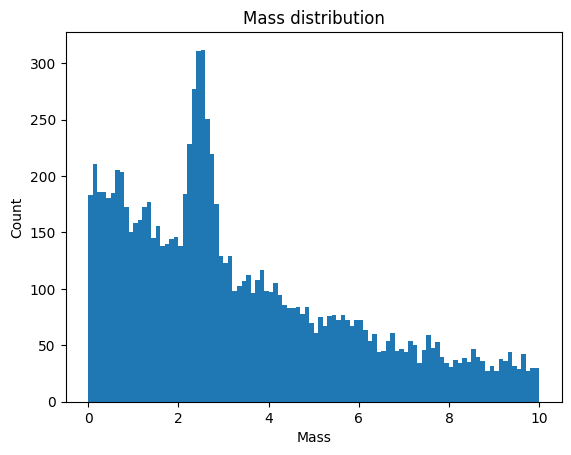

In [12]:
plt.hist(mass_samples, bins=100)
plt.title("Mass distribution")
plt.xlabel("Mass")
plt.ylabel("Count")
plt.show()

### Maximum likelihood fit to the data

In [13]:
# Generate the normalised exponential PDF
def Generate_exp_PDF(mass_samples,tau,mass_low,mass_high):
    C = np.exp(-mass_low/tau)-np.exp(-mass_high/tau) # Calculate the normalisation constant
    return (1/(tau*C))*np.exp(-mass_samples/tau) # Return the normalised exponential PDF

In [14]:
# Generate the guassian PDF
# No need to normalise the guassian PDF as the range of data on each side of the mean is many standard deviations away
# and therefore the data range can be accurately approximated as infinite
def Generate_gauss_PDF(mass_samples, mu):
    return scipy.stats.norm.pdf(mass_samples,mu,sigma) # Return the normalised gaussian PDF

In [15]:
# Generate the combined PDF of the normalised exponential and normalised gaussian PDFs
# This PDF is also normalised as the fraction it takes of the normalised gaussian and exponential PDFs adds up to 1
def PDF_combined(mass_samples,tau,mu,F,mass_low,mass_high):
    PDF1 = Generate_exp_PDF(mass_samples,tau,mass_low,mass_high)
    PDF2 = Generate_gauss_PDF(mass_samples,mu)
    
    return (F * PDF1) + ((1-F) * PDF2)

In [16]:
# Calculate the negative of the log of the joint likelihood
# This is the function we are trying to minimise with the minimiser, given different values of tau, mu and F
def NLL(tau,mu,F):
    P = PDF_combined(mass_samples,tau,mu,F,mass_low,mass_high)
    return -np.sum(np.log(P))

In [17]:
sigma = 0.2 # Using a fixed gaussian width of 0.2

# Setting the range of our mass data for use in normalisation
mass_low = 0 
mass_high = 10

# Set the minimisation parameters
m = Minuit(NLL, tau=3, mu=2, F=0.5)
m.limits["F"] = (0.0,1.0) 
m.limits["tau"] = (0.0,10.0) 
m.limits["mu"] = (1.0,9.0) # Limits on mu set many standard deviations away from data boundaries to accurately
                           # approximate infinite data range 

# Set the errors on the initial start values
m.errors=[0.1,0.1,0.1]

# Set the increase in NLL for the 1-SD error calculation
m.errordef=0.5

# Run the minimisation
m = m.migrad()

In [18]:
# Printing the final results and their error
fstr = "{0:2.4f}"
val = m.values["tau","mu","F"]
err = m.errors["tau","mu","F"]
print("{:2s}".format("tau"), "=  ", fstr.format(val[0]), " +/- ", fstr.format(err[0]))
print("\n")
print("{:2s}".format("mu"), "=  ", fstr.format(val[1]), " +/- ", fstr.format(err[1]))
print("\n")
print("{:2s}".format("F"), "=  ", fstr.format(val[2]), " +/- ", fstr.format(err[2]))

tau =   5.0434  +/-  0.1027


mu =   2.4998  +/-  0.0118


F  =   0.9029  +/-  0.0045


### Discussion of the results

First, separate PDFs were generated for the exponential and guassian distributions. The exponential PDF was explicitly normalised. The gaussian PDF was ensured to be normalised by restraining its mean from going less than 5 standard deviations away from the data boundaries and having its width fixed.

Secondly, reasonable initial parameter values and errors were provided to the minimizer and the error definition was adjusted.

Finally, the minimization was ran to produce the fitted values of tau, mu and F and their errors.

### Interpretation of the results

All three values that were obtained for tau, mu and F are, within their error margins, accurate to the true values that were used to generate the distribution that was used in the fitting.

The errors which are quoted for each value are of reasonable size.

Altogether, this indicates that the parameter fitting was successful.